# Purchase Card (PCard) Fiscal Year 2014's Feature Creation

Author: Huan Shuo Hsu

This dataset contains information on purchases made through the purchase card programs administered by the state and higher ed institutions. We will engineer at least 5 new features that could help in anomaly detection in an unsupervised ML context.

# Table of Contents
- <b>[Data Preparation](#1)</b>
  - [Load & Inspect Dataset](#11)
  - [Datatype Conversion](#12)
  - [Create Data Fields](#13)

- <b>[Initial observations](#2)</b>
  - [Time Series of Transactions Count](#21)
  - [Top Vendors / MCCs by Transaction Count](#22)

- <b>[Feature Engineering](#3)</b>
  - [Feature 1: Monetary](#31)
  - [Feature 2: Recency](#32)
  - [Feature 3: Frequency](#33)
  - [Feature 4: Recency + Monetary Aggregation](#34)
  - [Feature 5: Frequency + Monetary Aggregation](#35)


# Data Preparation <a class="anchor" id="1"></a>

## Load & Inspect Dataset <a class="anchor" id="11"></a>

In [275]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
from matplotlib.ticker import LogLocator

df = pd.read_csv("data/purchase_credit_card.csv")

df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [276]:
# check dimensions of the dataset, we found it has 442,458 rows and 11 columns 
print(df.shape)

# check column names
print(df.columns)

# Get the Simple Summary Statistics 
df.describe()

(442458, 11)
Index(['Year-Month', 'Agency Number', 'Agency Name', 'Cardholder Last Name',
       'Cardholder First Initial', 'Description', 'Amount', 'Vendor',
       'Transaction Date', 'Posted Date', 'Merchant Category Code (MCC)'],
      dtype='object')


,Year-Month,Agency Number,Amount
count,442458.000000,442458.000000,4.424580e+05
mean,201357.284375,42785.860353,4.249912e+02
std,47.107417,33378.461293,5.266509e+03
min,201307.000000,1000.000000,-4.286304e+04
25%,201309.000000,1000.000000,3.091000e+01
50%,201401.000000,47700.000000,1.048900e+02
75%,201404.000000,76000.000000,3.450000e+02
max,201406.000000,98000.000000,1.903858e+06


## Datatype Conversion <a class="anchor" id="12"></a>

In [277]:
# Check the data types
print(df['Transaction Date'].dtype)
print(df['Posted Date'].dtype)

object
object


In [278]:
# Convert dates to datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Posted Date'] = pd.to_datetime(df['Posted Date'])

# Check the data types again
print(df['Transaction Date'].dtype)
print(df['Posted Date'].dtype)


datetime64[ns]
datetime64[ns]


C:\Users\User\AppData\Local\Temp\ipykernel_29640\2475522457.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
C:\Users\User\AppData\Local\Temp\ipykernel_29640\2475522457.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Posted Date'] = pd.to_datetime(df['Posted Date'])


## Create Data Fields <a class="anchor" id="13"></a>

In [279]:
# Year_Month gives a monthly granularity key (useful for grouping transactions by month).
df['Year-Month']=pd.to_datetime(df['Year-Month'], format='%Y%m')

# Year and Month separately help with seasonality detection (e.g., fraud might spike every December).
df['Year'] = df['Year-Month'].dt.year
df['Month'] = df['Year-Month'].dt.month

# Initial Observations <a class="anchor" id="2"></a>

## Time Series of Transactions Count <a class="anchor" id="21"></a>

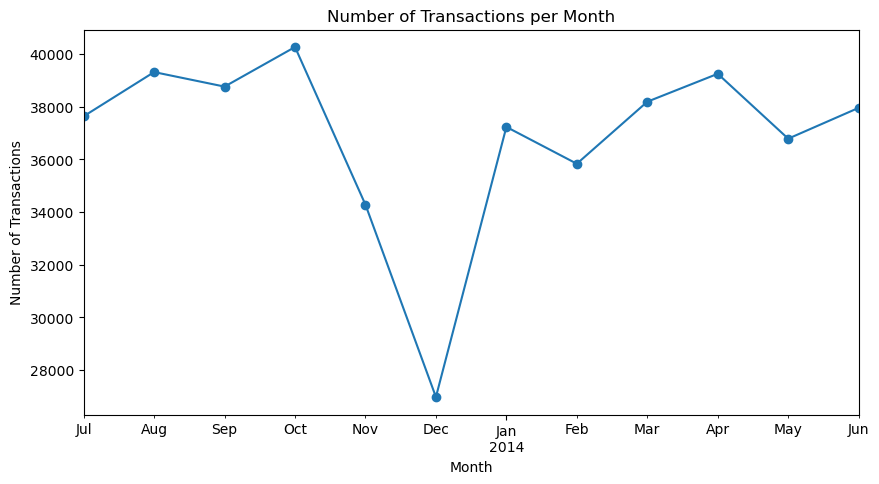

In [280]:
monthly_spend = df.groupby('Year-Month')['Amount'].count()
monthly_spend.plot(figsize=(10,5), marker='o')
plt.title("Number of Transactions per Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.show()


Observations:
- December shows a steep decline to ~27k transactions (a 30–35% drop)
- It could be due to missing data, reporting cutoff, or seasonal lull in this dataset.
- If this were fraud monitoring, the dip could hide under-reporting or strategic fraud gaps (fraudsters pausing activity)

## Top Vendors / MCCs by Transaction Count <a class="anchor" id="22"></a>

C:\Users\User\AppData\Local\Temp\ipykernel_29640\213478682.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vendors, y='Vendor', x='Amount', palette="Blues_r")


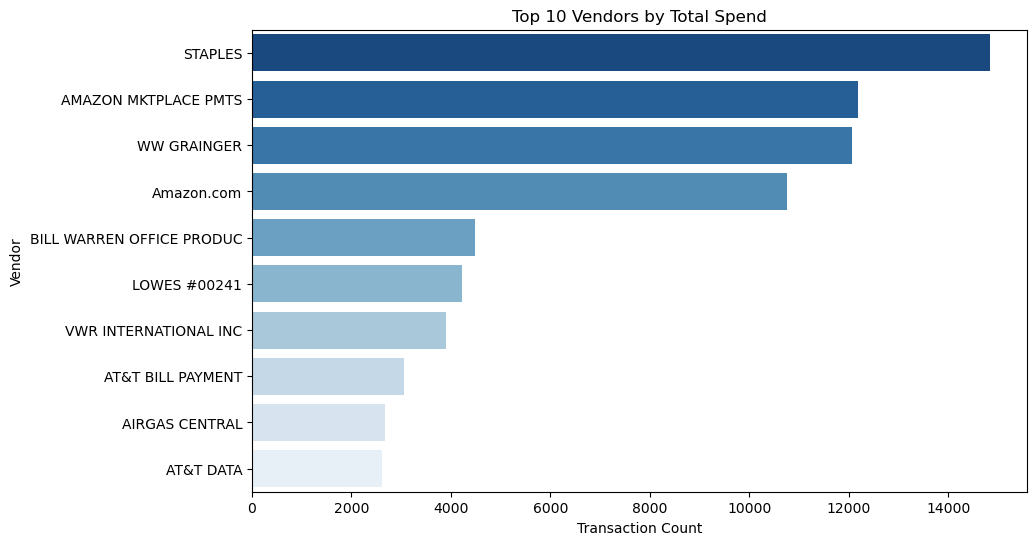

In [313]:
top_vendors = df.groupby('Vendor')['Amount'].count().reset_index()
top_vendors = top_vendors.sort_values('Amount', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_vendors, y='Vendor', x='Amount', palette="Blues_r")
plt.title("Top 10 Vendors by Total Spend")
plt.xlabel("Transaction Count")
plt.ylabel("Vendor")
plt.show()

Observations:
- We can also look at the top vendors and MCCs by transaction count to identify any unusual patterns or outliers.

# Feature Engineering <a class="anchor" id="3"></a>

## Feature 1: Recency <a class="anchor" id="31"></a> 

Recency measures the time since a cardholder’s last transaction.  
- Very **short recency** (multiple purchases within minutes/hours) may indicate high-velocity fraud.  
- Very **long recency** followed by sudden re-activation may also be suspicious.  

**Implementation:**  
We sort transactions by cardholder and transaction date, then compute the time difference (in days) between consecutive transactions.

### Recency Days

In [291]:
# Ensure sorted by cardholder + transaction time
df = df.sort_values(['Cardholder Last Name','Transaction Date'])

# Calculate days since last transaction for each cardholder
df['Recency days'] = df.groupby('Cardholder Last Name')['Transaction Date'].diff().dt.days

df[['Cardholder Last Name','Transaction Date','Amount','Recency days']].head(10)


,Cardholder Last Name,Transaction Date,Amount,Recency days
295887,15000,2014-03-10,4626.46,NaN
95546,24100,2013-07-15,16.90,NaN
95555,24100,2013-07-25,1796.09,10.0
95614,24100,2013-08-15,14.53,21.0
95635,24100,2013-08-26,734.50,11.0
95715,24100,2013-09-13,6.54,18.0
95841,24100,2013-12-13,0.04,91.0
95855,24100,2013-12-26,250.00,13.0
95884,24100,2014-01-15,0.77,20.0
297113,24100,2014-03-14,-35.29,58.0


Observations:

- **Short Recency** (e.g., 0–1 days): A cardholder making multiple purchases within the same day or across consecutive days may indicate:

    - Normal behavior (daily groceries, travel tickets).

    - Fraudulent “velocity” spending (fraudsters quickly exploit stolen cards).


- **Long Recency** (e.g., 60–90+ days): A dormant card suddenly being used again may be:

    - A genuine return to activity.

    - Suspicious reactivation after theft.


--

Interpretation:

- NaN on the first transaction: Expected (no prior transaction).

- Recency values: show gaps of 10, 21, 11, 18, 91, 13, 20, 58 days between purchases.

- Notice the 91-day gap → potentially interesting anomaly for this cardholder.

### Average Recency per Cardholder

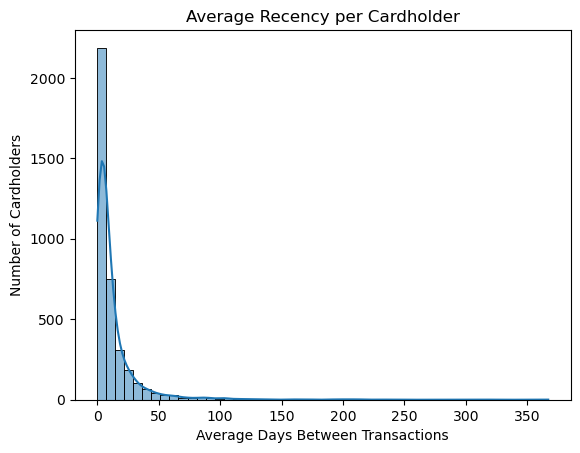

In [283]:
avg_recency = df.groupby('Cardholder Last Name')['Recency days'].mean().dropna()
sns.histplot(avg_recency, bins=50, kde=True)
plt.title("Average Recency per Cardholder")
plt.xlabel("Average Days Between Transactions")
plt.ylabel("Number of Cardholders")
plt.show()


Observation:
- We can see that most average days between transactions is within 50 days. Therefore, we can flag transactions with recency > 50 days as potentially anomalous.

### Top Recency Gaps

In [284]:
# Drop rows with NaN recency (first transaction per cardholder has no prior gap)
recency_sorted = df[['Cardholder Last Name','Transaction Date','Amount','Recency days']] \
    .dropna() \
    .sort_values(by='Recency days', ascending=False)

# Show top 10 longest gaps
recency_sorted.head(20)

,Cardholder Last Name,Transaction Date,Amount,Recency days
394867,Basco,2014-06-29,395.46,367.0
426976,BUGHER,2014-06-25,125.00,352.0
380768,Gardner ch,2014-06-12,84.59,338.0
423126,GLATZHOFER,2014-05-30,753.51,332.0
382257,Williams CH,2014-06-10,150.00,321.0
405319,Chewey,2014-05-29,202.58,320.0
397545,O'Donnell,2014-05-11,100.00,317.0
386287,Russell,2014-06-23,725.39,314.0
418286,DRASS,2014-05-07,89.97,310.0
398234,Kildow,2014-06-18,81.34,306.0


We can then rank the top cardholders by their longest recency gaps to identify unusual inactivity periods.

## Feature 2: Monetary <a class="anchor" id="32"></a> 

Monetary represents the **spending level** of a cardholder.  
- Most cardholders have consistent spending patterns.  
- A sudden spike in average spend or a large deviation from historical behavior may indicate an anomaly.  

**Implementation:**  
We calculate a 30-day rolling **average spend per cardholder**, and also a **spend deviation ratio** (current amount ÷ rolling average).


### Transaction Amount Distribution

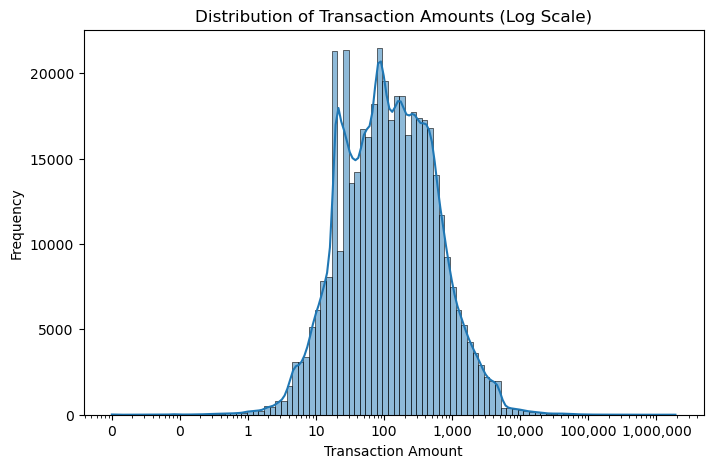

In [285]:
plt.figure(figsize=(8,5))
sns.histplot(df['Amount'], bins=100, log_scale=True, kde=True)

# Major ticks only at powers of 10
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=10))

# Format as plain integers
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.title("Distribution of Transaction Amounts (Log Scale)")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

Observations:
- The majority of transactions cluster between $10 and $1,000, which represents typical cardholder spending behavior.

- There are noticeable numbers of very small transactions (<$1), which could be normal micro-purchases or fraud test charges.

- The distribution has a long right tail, with some transactions reaching tens of thousands or more. These are rare and potentially anomalous.

- verall, the data follows a log-normal distribution: many small/medium values, fewer large values, and extreme outliers.

### Spend Deviation Ratio

In [293]:
# Calculate 30-day rolling average spend
df['Rolling Avg 30d'] = df.groupby('Cardholder Last Name')['Amount'] \
    .transform(lambda x: x.rolling(30, min_periods=1).mean())

# Deviation = how different current txn is from normal pattern
df['Spend Deviation'] = df['Amount'] / df['Rolling Avg 30d']

# Random 10 transactions with Spend Deviation values
random_dev = df[['Cardholder Last Name','Transaction Date','Amount','Rolling Avg 30d','Spend Deviation']] \
    .sample(10, random_state=42)   # random_state for reproducibility

random_dev


,Cardholder Last Name,Transaction Date,Amount,Rolling Avg 30d,Spend Deviation
121988,JOHNSON,2013-09-20,20.00,337.731333,0.059219
383724,West,2014-06-03,383.62,480.891000,0.797728
29418,Bowers,2013-09-19,80.17,145.961000,0.549256
181987,BRAUN,2013-10-17,255.45,102.332083,2.496285
137073,Meek,2013-09-10,98.95,177.322000,0.558024
224344,XU,2013-10-01,589.00,449.483667,1.310392
98467,Pauley,2013-07-22,980.00,432.743333,2.264622
372440,Scott,2014-04-29,1425.00,390.935000,3.645107
138098,Kerns,2013-10-08,71.82,312.071250,0.230140
267636,Biggerstaff,2014-03-25,10.39,169.739259,0.061212


Observations:

- Rolling Average Spend (Rolling_Avg_30d) captures the baseline of a cardholder’s typical spending over a 30-day window.


- Spend Deviation highlights when a transaction diverges from that baseline:

    - A deviation close to 1.0 means the transaction matches normal spending.

    - A deviation much greater than 1.0 signals an unusually large spend.

    - A deviation near zero signals a very small purchase compared to history.

    - A negative value indicates refunds or reversals.

(There are mix of names and numbers for cardholders last name.)

--

Interpretation:

- Scott (2014-04-29, Amount = 1425.00)

    - Rolling average = 390.94, Spend Deviation ≈ 3.65.

    - Nearly 4× higher than usual → very strong anomaly, high-risk transaction.

- Braun (2013-10-17, Amount = 255.45)

    - Rolling average = 102.33, Spend Deviation ≈ 2.50.

    - More than double the baseline → potential anomaly worth monitoring.

- Pauley (2013-07-22, Amount = 980.00)

    - Rolling average = 432.74, Spend Deviation ≈ 2.26.

    - Over 2× typical spend → unusual large purchase.

- Johnson (2013-09-20, Amount = 20.00)

    - Rolling average = 337.73, Spend Deviation ≈ 0.06.

    - Very small transaction compared to baseline → could be a fraud “test” charge.

- Biggerstaff (2014-03-25, Amount = 10.39)

    - Rolling average = 169.74, Spend Deviation ≈ 0.06.

    - Another tiny charge far below normal → suspicious behavior.


## Feature 3: Frequency <a class="anchor" id="33"></a> 

Frequency measures how often a cardholder makes transactions in a given time period. Abnormalities may include:

- **Unusually high frequency** (e.g., many transactions in a single day/hour → could be fraudsters “maxing out” a stolen card).

- **Unusually low frequency** compared to the cardholder’s history (e.g., inactivity → dormant accounts suddenly reactivated).

**Implementation:**  
We will compute the **frequency of transaction** for each cardholder on a daily basis.


### Distrution of Daily Frequency

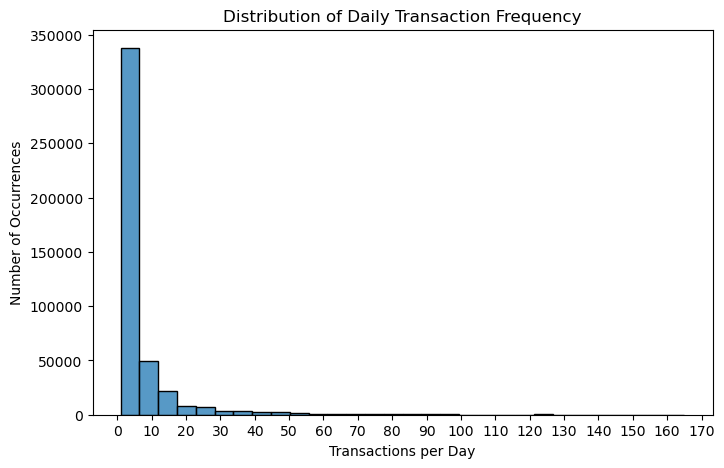

In [301]:
plt.figure(figsize=(8,5))
sns.histplot(df['Txn_Count_Daily'], bins=30, kde=False)
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(10))
plt.title("Distribution of Daily Transaction Frequency")
plt.xlabel("Transactions per Day")
plt.ylabel("Number of Occurrences")
plt.show()


Observations:
- Most activity is very low frequency:

    - The vast majority of cardholders make 1–10 transactions per day.

    - This aligns with normal consumer/business usage (groceries, meals, travel).

- Long right tail:

    - A small number of cardholders show 20–50 transactions in a single day.

    - These are much less common, but could be explained by business accounts, travel bookings, or expense batching.

- Extreme outliers:

    - Very rare cases exceed 100+ transactions in a day.

    - These are highly suspicious — consistent with velocity fraud (fraudster repeatedly using the card in a short time).

### Top 10 Highest Daily Transaction Frequencies

In [302]:
# Top 10 highest daily transaction frequencies
top10_freq = (
    df[['Cardholder Last Name','Transaction Date','Txn_Count_Daily']]
    .drop_duplicates()  # avoid repeating the same cardholder-date row
    .sort_values(by='Txn_Count_Daily', ascending=False)
    .head(10)
)

top10_freq


,Cardholder Last Name,Transaction Date,Txn_Count_Daily
199827,JOURNEY HOUSE TRAVEL INC,2014-01-10,165
196525,JOURNEY HOUSE TRAVEL INC,2013-12-20,125
198833,UNIVERSITY AMERICAN,2014-01-17,124
204274,JOURNEY HOUSE TRAVEL INC,2014-01-07,121
344787,JOURNEY HOUSE TRAVEL INC,2014-04-29,105
201906,UNIVERSITY AMERICAN,2014-01-27,99
194623,JOURNEY HOUSE TRAVEL INC,2013-12-03,97
332118,UNIVERSITY AMERICAN,2014-03-06,95
76727,Paulk,2013-11-19,94
193684,JOURNEY HOUSE TRAVEL INC,2013-12-10,93


Observations:
- Now we are seeing top 20 highest daily transaction frequencies.
- But there is one issue, some of these account are obviously business accounts, so we need to filter them out in aggregate analysis to actually find the anomalies.

## R, F, M Summary
- A high frequency alone might be explained by a business account.

- A large transaction amount alone might be explained by legitimate big purchases.

- A long recency gap alone might just mean a cardholder didn’t use their card for a while.

So how can we be more confident in flagging anomalies? certain that a transaction is anomalous? By combining R, F, and M features together!

## Feature 4: Recency–Monetary Aggregation <a class="anchor" id ="34"></a>

Recency measures the time gap since the last transaction, while Monetary measures the spending amount relative to normal behavior.
When combined, they can highlight suspicious behaviors such as:

- Short recency + High spend deviation
(e.g., multiple transactions in quick succession where one is much larger than usual → potential fraud burst).

- Long recency + High spend deviation
(e.g., card was dormant for months, then suddenly used for a large transaction → possible reactivation fraud).

Implementation:
- We will create a combined feature that flags transactions where recency is abnormally short/long and monetary deviation is high.

In [304]:
# Flag short recency (transactions within 1 day)
df['Recency_Flag'] = (df['Recency days'] <= 1).astype(int)

# Flag long recency (>=60 days inactivity)
df['Dormancy_Flag'] = (df['Recency days'] >= 60).astype(int)

# Flag high spend deviation (>=2x typical spend)
df['High_Spend_Flag'] = (df['Spend Deviation'] >= 2).astype(int)

# Combine: suspicious if high spend AND either too short or too long recency
df['RecMon_Anomaly'] = (
    (df['High_Spend_Flag'] == 1) &
    ((df['Recency_Flag'] == 1) | (df['Dormancy_Flag'] == 1))
).astype(int)

# Preview top suspicious cases
df[['Cardholder Last Name','Transaction Date','Amount','Recency days',
    'Spend Deviation','RecMon_Anomaly']].head(15)


,Cardholder Last Name,Transaction Date,Amount,Recency days,Spend Deviation,RecMon_Anomaly
295887,15000,2014-03-10,4626.46,NaN,1.000000,0
95546,24100,2013-07-15,16.90,NaN,1.000000,0
95555,24100,2013-07-25,1796.09,10.0,1.981357,0
95614,24100,2013-08-15,14.53,21.0,0.023852,0
95635,24100,2013-08-26,734.50,11.0,1.146751,0
95715,24100,2013-09-13,6.54,18.0,0.012731,0
95841,24100,2013-12-13,0.04,91.0,0.000093,0
95855,24100,2013-12-26,250.00,13.0,0.620876,0
95884,24100,2014-01-15,0.77,20.0,0.002185,0
297113,24100,2014-03-14,-35.29,58.0,-0.114081,0


Observations:
- This is the overview of the Recency-Monetary combined anomaly detection. All of the above transactions are not flagged. Recmon_Anomaly = 1 means either Recency_Flag = 1 or Dormancy_Flag = 1. If 0, it is not flagged.

### Top 20 Recency-Monetary Anomalies

In [309]:
# Added Spend Deviation Clean (handles infinities + caps at 50).
suspicious = df[df['RecMon_Anomaly'] == 1].copy()

# Replace inf/-inf with NaN, then cap extreme values
suspicious['Spend Deviation Clean'] = suspicious['Spend Deviation'].replace([np.inf, -np.inf], np.nan)
suspicious['Spend Deviation Clean'] = suspicious['Spend Deviation Clean'].clip(lower=0, upper=50)

# Remove obvious business accounts
business_keywords = ['INC', 'LLC', 'CORP', 'COMPANY', 'TRAVEL', 'SCHOOL', 'UNIVERSITY']
suspicious = suspicious[~suspicious['Cardholder Last Name'].str.upper().str.contains('|'.join(business_keywords))]

# Remove refunds (negative amounts)
suspicious = suspicious[suspicious['Amount'] >= 0]

# Get top anomalies after cleaning
top10_recmon_clean = suspicious.sort_values(by='Spend Deviation Clean', ascending=False).head(20)

top10_recmon_clean[['Cardholder Last Name','Transaction Date','Amount',
                    'Recency days','Spend Deviation','Spend Deviation Clean','RecMon_Anomaly']]


,Cardholder Last Name,Transaction Date,Amount,Recency days,Spend Deviation,Spend Deviation Clean,RecMon_Anomaly
312742,Gordon,2014-04-15,106.78,0.0,61.473805,50.000000,1
353682,ARTHUR,2014-03-27,2337.40,0.0,50.546393,50.000000,1
336101,NICAR,2014-03-24,99.00,0.0,566.793893,50.000000,1
4677,Baughman,2013-07-11,1063.22,0.0,59.642109,50.000000,1
78062,Diffee,2014-01-08,722.00,1.0,66.531515,50.000000,1
15897,Brown,2013-08-07,1418.64,0.0,58.798856,50.000000,1
15607,Elmore,2013-08-02,4999.00,0.0,191.520337,50.000000,1
94462,Garcia,2013-07-02,450.00,1.0,52.693208,50.000000,1
214740,HANNAH,2013-08-27,285.50,0.0,60.887183,50.000000,1
209597,STURGEON,2013-07-01,299.00,0.0,81.250000,50.000000,1


Observations:
- The anomalies reflect sudden deviations in spending patterns rather than just absolute transaction size.

- Small transactions with huge deviations (e.g., Gunn – $20 but 45× baseline, NICAR – $99 but 50× baseline) suggest possible card testing behavior, where fraudsters try small charges first.

- Large transactions with extreme deviations (e.g., Elmore – $4,999, Wilborn – $2,591, Arthur – $2,337) indicate potential cash-out fraud or unusually large purchases outside normal behavior.

- Moderate spends with high deviation (e.g., Gordon – $106 at 50×, Taylor – $603 at 46×) show outliers relative to very low-spending accounts, highlighting accounts that are typically dormant.

- Overall, anomalies split into two suspicious patterns:

    - Low-dollar, high-deviation “test” charges.

    - High-dollar, high-deviation spikes that could indicate fraudsters exploiting an account.

## Feature 5: Frequeny + Monetary Aggregation <a class="anchor" id ="35"></a>

This feature captures cases where a cardholder makes many transactions in a short period, combined with high spending levels.
- Fraudsters often run many charges in rapid succession (“velocity attacks”) to test limits or maximize stolen card value.
- Genuine customers rarely make 10+ purchases per day with high dollar amounts.
- By combining frequency and monetary, we can filter out cases where the count is high but amounts are trivial (like splitting a bill), and focus on high-volume, high-value behavior.

Implementation:
- We count daily transactions per cardholder (Txn_Count_Daily) and pair it with the daily total spend. Then we flag anomalies when frequency AND total spend exceed thresholds.

In [310]:
# Daily frequency and spend per cardholder
df['Txn_Count_Daily'] = df.groupby(['Cardholder Last Name','Transaction Date'])['Amount'].transform('count')
df['Daily_Spend'] = df.groupby(['Cardholder Last Name','Transaction Date'])['Amount'].transform('sum')

# Flag high frequency (>=10 txns in a day)
df['High_Freq_Flag'] = (df['Txn_Count_Daily'] >= 10).astype(int)

# Flag high daily spend (>= $2000 in a day)
df['High_Spend_Flag_Day'] = (df['Daily_Spend'] >= 2000).astype(int)

# Combine: suspicious if BOTH are true
df['FreqMon_Anomaly'] = ((df['High_Freq_Flag'] == 1) & (df['High_Spend_Flag_Day'] == 1)).astype(int)

# Preview anomalies
freqmon_top = df[df['FreqMon_Anomaly'] == 1][
    ['Cardholder Last Name','Transaction Date','Txn_Count_Daily','Daily_Spend','FreqMon_Anomaly']
].drop_duplicates().sort_values(by=['Txn_Count_Daily','Daily_Spend'], ascending=False).head(20)

freqmon_top


,Cardholder Last Name,Transaction Date,Txn_Count_Daily,Daily_Spend,FreqMon_Anomaly
199827,JOURNEY HOUSE TRAVEL INC,2014-01-10,165,57252.90,1
196525,JOURNEY HOUSE TRAVEL INC,2013-12-20,125,31103.26,1
198833,UNIVERSITY AMERICAN,2014-01-17,124,43664.04,1
204274,JOURNEY HOUSE TRAVEL INC,2014-01-07,121,44201.47,1
344787,JOURNEY HOUSE TRAVEL INC,2014-04-29,105,34211.93,1
201906,UNIVERSITY AMERICAN,2014-01-27,99,44186.02,1
194623,JOURNEY HOUSE TRAVEL INC,2013-12-03,97,4958.68,1
332118,UNIVERSITY AMERICAN,2014-03-06,95,44738.12,1
339723,JOURNEY HOUSE TRAVEL INC,2014-04-17,93,48480.36,1
193684,JOURNEY HOUSE TRAVEL INC,2013-12-10,93,34653.21,1


Observations:
- The FreqMon anomaly output is being dominated by business/institution accounts (e.g., Journey House Travel Inc, University American). These aren’t personal cardholders; they’re high-volume merchants or corporate accounts.

### Top 10 Highest Frequency + Monetary Anomalies

In [312]:
# Daily frequency and spend per cardholder
df['Txn_Count_Daily'] = df.groupby(['Cardholder Last Name','Transaction Date'])['Amount'].transform('count')
df['Daily_Spend'] = df.groupby(['Cardholder Last Name','Transaction Date'])['Amount'].transform('sum')

# Flag high frequency (>=10 txns in a day)
df['High_Freq_Flag'] = (df['Txn_Count_Daily'] >= 10).astype(int)

# Flag high daily spend (>= $2000 in a day)
df['High_Spend_Flag_Day'] = (df['Daily_Spend'] >= 2000).astype(int)

# Combine: suspicious if BOTH are true
df['FreqMon_Anomaly'] = ((df['High_Freq_Flag'] == 1) & (df['High_Spend_Flag_Day'] == 1)).astype(int)

# IMPROVEMENTS (Removing business accounts/institutions, refunds)
# Remove business/institution accounts (simple keyword filter)
business_keywords = ['INC','LLC','CORP','COMPANY','TRAVEL','SCHOOL','UNIVERSITY']
mask_business = df['Cardholder Last Name'].str.upper().str.contains('|'.join(business_keywords))

# Keep only consumer-like suspicious anomalies (no business accounts, no refunds)
suspicious = df[(df['FreqMon_Anomaly'] == 1) & (~mask_business) & (df['Daily_Spend'] > 0)]

# Preview clean top anomalies
freqmon_top = suspicious[
    ['Cardholder Last Name','Transaction Date','Txn_Count_Daily','Daily_Spend','FreqMon_Anomaly']
].drop_duplicates().sort_values(by=['Txn_Count_Daily','Daily_Spend'], ascending=False).head(20)

freqmon_top


,Cardholder Last Name,Transaction Date,Txn_Count_Daily,Daily_Spend,FreqMon_Anomaly
109514,LAMBERT,2013-09-11,68,4552.81,1
110284,Lewis,2013-10-18,63,45245.81,1
374453,Stevenson,2014-05-02,62,13088.57,1
202077,LARSON,2014-01-30,61,137912.83,1
131640,Batenhorst,2014-01-15,58,2712.24,1
113400,Lewis,2013-12-04,55,43430.08,1
207801,TAYLOR,2013-06-28,52,4280.59,1
102663,Lewis,2013-11-13,50,19751.33,1
207737,WALKER,2013-06-28,50,4808.84,1
107836,Freeman,2013-08-14,50,2691.72,1


Observations:
- Very high transaction counts (40–68 per day):

    - Multiple cardholders (e.g., LAMBERT, Lewis, Stevenson, Larson) are making 40–60+ transactions in a single day.

    - This is far above typical consumer behavior (most individuals rarely exceed 10–15/day).

- Extremely high daily spend totals:

    - LARSON (2014-01-30) spent $137,913 in 61 transactions → exceptionally high and highly anomalous for an individual.

    - Lewis (2013-10-18) spent $45,245 across 63 transactions, suggesting either large purchases or systematic misuse.

- Consistent high-frequency patterns:

    - Lewis appears multiple times (Nov, Dec 2013) with 50–60 transactions/day, often exceeding $20k–40k in daily spend → this pattern indicates recurring unusual activity.

    - Batenhorst shows 46–58 daily transactions, though with smaller daily totals ($2k–2.7k), which may indicate high-volume micro-purchases.

- Mid-range anomalies (40–50 transactions/day):

    - Examples: Hines, Gomez, Sallee, Stevenson.

    - These cardholders consistently exceed 40 daily transactions, with spend ranging from $3k to $33k → still anomalous compared to normal card usage.

Interpretation:
- High-frequency + high-spend combinations are strong anomaly indicators.

- Lewis & Larson stand out as the most suspicious due to repeated high activity and extreme dollar amounts.

- Batenhorst, Hines, Stevenson highlight another pattern: moderate spend but excessively high frequency, which may signal fraud attempts through smaller, repeated charges.